In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")


np.random.seed(19)

In [37]:
class PolyRegression(BaseEstimator):
    
    def __init__(self, degree=1, reg=None, alpha=0.5):
        self.poly = PolynomialFeatures(degree)
        self.reg = reg
        self.alpha = alpha
        self.degree = degree
        
    def fit(self, data, labels):
        X = self.poly.fit_transform(data)
        if self.reg == None:
            self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), labels)
        elif self.reg == 'ridge':
            self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + self.alpha * np.eye(X.shape[1])), X.T), labels)
        elif self.reg == 'lasso':
            est = Lasso(alpha=self.alpha,
                        fit_intercept=False,
                        max_iter=10**6)
            est.fit(X, labels)
            self.w = est.coef_
        else:
            raise ValueError('Unsupported regularization method')
        return self
        
    def predict(self, data):
        X = self.poly.transform(data)
        return np.dot(X, self.w)
    
    def plot_predict(self, X_tr, X_te, y_tr, y_te, ax=None, N=100, eps=3):
        
        preds = self.predict(X_te)
        r_score = round(r2_score(y_te, preds), 3)
        
        min_, max_ = min(np.min(X_tr), np.min(X_te)), max(np.max(X_tr), np.max(X_te))
        rng = np.linspace(min_-eps, max_+eps, N).reshape(-1, 1)
        rng_preds = self.predict(rng)
        
        if ax == None:
            fig, ax = plt.subplots(figsize=[9, 9])
        ax.scatter(X_tr, y_tr, label='Train')
        ax.scatter(X_te, y_te, label='Test', c='r')
        ax.set_xlim(min_-eps, max_+eps)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        if self.reg:
            ax.set_title(
                f'Degree = {self.poly.degree}, Method = {self.reg}, Alpha = {round(self.alpha, 3)}')
        else:
            ax.set_title(f'Degree = {self.poly.degree}')
        
        ax.plot(rng, rng_preds, label=f'$R^2$ = {r_score}')
        ax.legend()
        
    def score(self, data, labels):
        preds = self.predict(data)
        score_ = r2_score(labels, preds)
        print(f'R^2 score = {score_}')
        return score_
    
def FindBest(model, data, labels, alphas, mode=None):
    cv = KFold(5, True)
    param_grid = {'alpha': alphas}
    GS = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
    GS.fit(data, labels)
    best = GS.best_estimator_
    
    if mode == 'hydro':
        print('Best parameters:')
        print(GS.best_params_)
        print('Best R2 score:')
        print(GS.best_score_)
    
    if model.reg == 'lasso':
        nonzero = np.sum(best.w != 0)
        print(f'{nonzero} non zero coefficients out of {len(best.w)}')
        
        
    return best

## Noisy sine:

In [9]:
sine = pd.read_csv('Data/noisysine.csv')
data_sine = sine['x'].values.reshape(-1, 1)
labels_sine = sine['y'].values

In [10]:
X_tr_sine, X_te_sine, y_tr_sine, y_te_sine = train_test_split(sine['x'].values,
                                                              sine['y'].values,
                                                              test_size=0.2)

### Plain regression:

In [25]:
lr = PolyRegression(degree=1)
_ = lr.fit(X_tr_sine.reshape([-1, 1]), y_tr_sine)

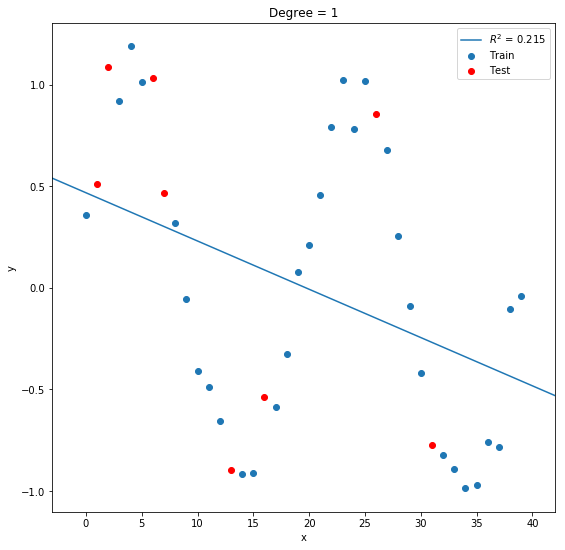

In [26]:
lr.plot_predict(X_tr_sine, X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine)

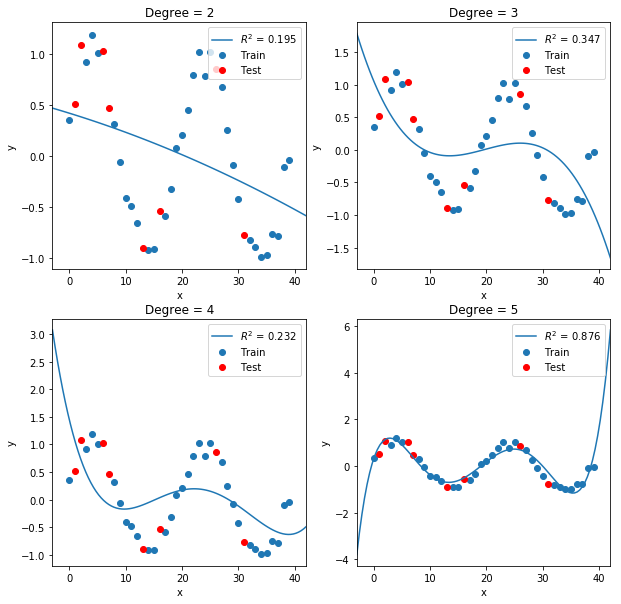

In [27]:
fig, axarr = plt.subplots(2, 2, figsize=[10, 10])
degrees = range(2, 6)
for i, d in enumerate(degrees):
    ax = axarr[i//2][i%2]
    est = PolyRegression(d)
    est.fit(X_tr_sine.reshape(-1, 1), y_tr_sine)
    est.plot_predict(X_tr_sine, X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine, ax)

### Ridge:

In [28]:
alphas = np.logspace(-9, 2, 34)
print(alphas)

[1.00000000e-09 2.15443469e-09 4.64158883e-09 1.00000000e-08
 2.15443469e-08 4.64158883e-08 1.00000000e-07 2.15443469e-07
 4.64158883e-07 1.00000000e-06 2.15443469e-06 4.64158883e-06
 1.00000000e-05 2.15443469e-05 4.64158883e-05 1.00000000e-04
 2.15443469e-04 4.64158883e-04 1.00000000e-03 2.15443469e-03
 4.64158883e-03 1.00000000e-02 2.15443469e-02 4.64158883e-02
 1.00000000e-01 2.15443469e-01 4.64158883e-01 1.00000000e+00
 2.15443469e+00 4.64158883e+00 1.00000000e+01 2.15443469e+01
 4.64158883e+01 1.00000000e+02]


In [29]:
lr = PolyRegression(1, 'ridge')
best_lr = FindBest(lr, data_sine, labels_sine, alphas)
_ = best_lr.fit(X_te_sine.reshape(-1, 1), y_te_sine)

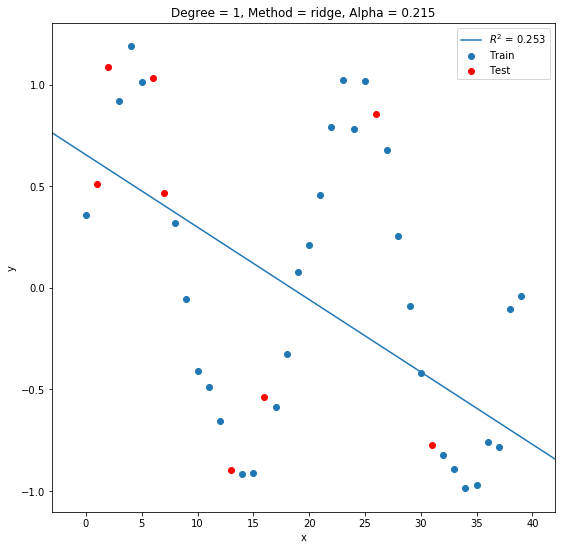

In [30]:
best_lr.plot_predict(X_tr_sine.reshape(-1, 1), X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine)

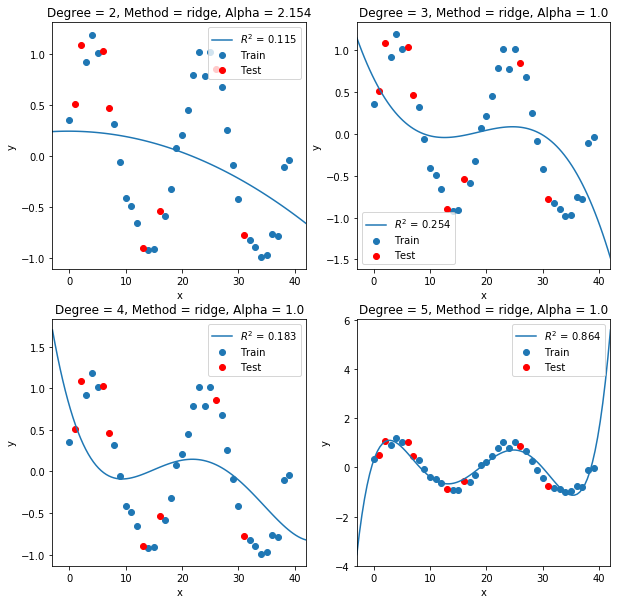

In [33]:
fig, axarr = plt.subplots(2, 2, figsize=[10, 10])
degrees = range(2, 6)
for i, d in enumerate(degrees):
    ax = axarr[i//2][i%2]
    est = PolyRegression(d, 'ridge')
    best_est = FindBest(est, data_sine, labels_sine, alphas)
    best_est.fit(X_tr_sine.reshape(-1, 1), y_tr_sine)
    best_est.plot_predict(X_tr_sine, X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine, ax)

### Lasso:

In [34]:
lr = PolyRegression(1, 'lasso')
best_lr = FindBest(lr, data_sine, labels_sine, alphas)
_ = best_lr.fit(X_te_sine.reshape(-1, 1), y_te_sine)

2 non zero coefficients out of 2


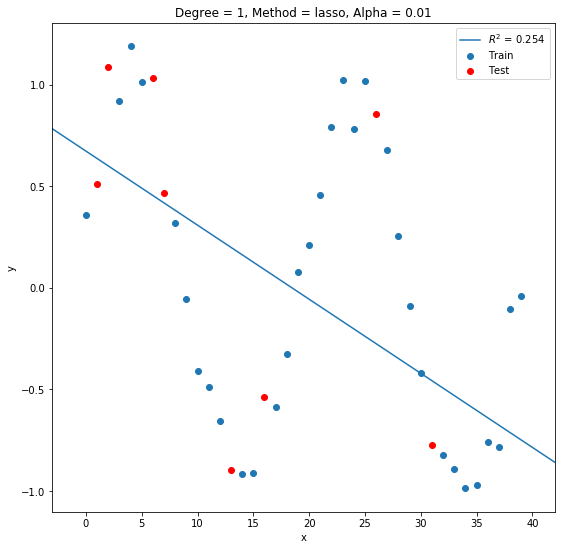

In [35]:
best_lr.plot_predict(X_tr_sine.reshape(-1, 1), X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine)

Degree = 2
3 non zero coefficients out of 3
Degree = 3
4 non zero coefficients out of 4
Degree = 4
2 non zero coefficients out of 5
Degree = 5
6 non zero coefficients out of 6


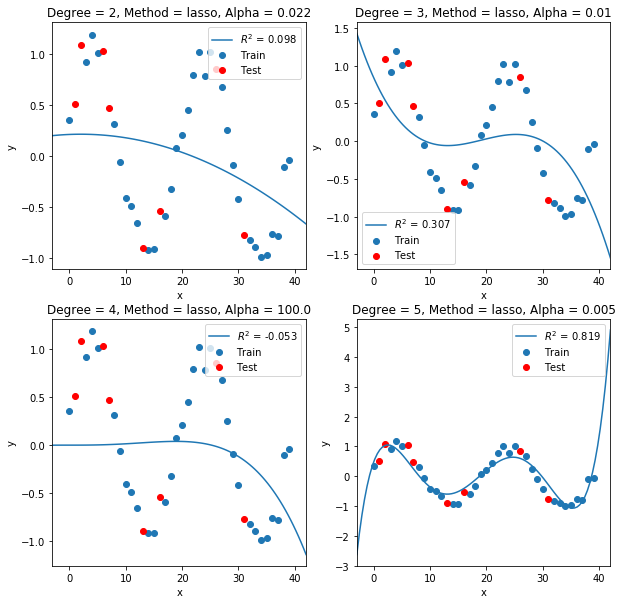

In [38]:
fig, axarr = plt.subplots(2, 2, figsize=[10, 10])
degrees = range(2, 6)
for i, d in enumerate(degrees):
    ax = axarr[i//2][i%2]
    est = PolyRegression(d, 'lasso')
    print(f'Degree = {d}')
    best_est = FindBest(est, data_sine, labels_sine, alphas)
    best_est.fit(X_tr_sine.reshape(-1, 1), y_tr_sine)
    best_est.plot_predict(X_tr_sine, X_te_sine.reshape(-1, 1), y_tr_sine, y_te_sine, ax)

## Hydrodynamics:

In [39]:
hydro = pd.read_csv('Data/hydrodynamics.csv')
print(hydro.shape)
labels_hydro = hydro['y'].values
data_hydro = hydro.drop(columns='y').values
hydro.head()

(308, 7)


,x0,x1,x2,x3,x4,x5,y
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [51]:
X_tr_hydro, X_te_hydro, y_tr_hydro, y_te_hydro = train_test_split(data_hydro,
                                                                  labels_hydro,
                                                                  test_size=0.2)

### Plain regression:

In [52]:
#Degree 1
lr = PolyRegression(1)
lr.fit(X_tr_hydro, y_tr_hydro)
_ = lr.score(X_te_hydro, y_te_hydro)

R^2 score = 0.6013116185997917


In [53]:
#Degree 2
pr2 = PolyRegression(2)
pr2.fit(X_tr_hydro, y_tr_hydro)
_ = pr2.score(X_te_hydro, y_te_hydro)

R^2 score = 0.8876211901614418


### Ridge regression:

In [49]:
#Degree 1
lr = PolyRegression(1, 'ridge')
_ = FindBest(lr, data_hydro, labels_hydro, alphas, mode='hydro')

Best parameters:
{'alpha': 0.1}
Best R2 score:
0.6337626675441005


In [50]:
#Degree 2
lr = PolyRegression(2, 'ridge')
_ = FindBest(lr, data_hydro, labels_hydro, alphas, mode='hydro')

Best parameters:
{'alpha': 0.001}
Best R2 score:
0.9137571751740652


### Lasso regression:

In [54]:
#Degree 1
lr = PolyRegression(1, 'lasso')
_ = FindBest(lr, data_hydro, labels_hydro, alphas, mode='hydro')

Best parameters:
{'alpha': 0.1}
Best R2 score:
0.6036365935265325
4 non zero coefficients out of 7


In [55]:
#Degree 2
lr = PolyRegression(2, 'lasso')
best = FindBest(lr, data_hydro, labels_hydro, alphas, mode='hydro')

Best parameters:
{'alpha': 0.002154434690031882}
Best R2 score:
0.9144642970256908
17 non zero coefficients out of 28
